In [100]:
import sys
import math
import numpy as np
from numpy import pi, sqrt, inf, log
from ecell4 import *

L = 100
voxel_radius = 0.005
D = 1
rng = GSLRandomNumberGenerator()
rng.seed(1)
kD = 4 * pi * (2 * voxel_radius) * D
ka_factor = 0.1#00.0
ka = kD * ka_factor
r0=0.256318
Pacc = 2#(1/r0-1)*ka_factor#ka / (6 * sqrt(2) * D * voxel_radius)
print('P',Pacc)
dt = (4 * voxel_radius * voxel_radius) / (6 * D)
maxstep= 5#10000
ntrials = int(1e9)#0000#100000
p=1

w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxel_radius, Integer3(3, 3, 3), rng)

def singlerunA(dt, Pacc,alpha):
    assert Pacc*alpha  <= 1
    assert alpha<=1

    coord1 = w.position2coordinate(ones() * L * 0.5)
    coord2 = w.get_neighbor(coord1, 0)

    dt = dt*alpha
    t, nsteps = 0.0, 0
    while all(0 <= dim < L for dim in w.coordinate2position(coord2)) and nsteps < maxstep:
        rnd = w.rng().uniform_int(0, 11)
        newcoord = w.get_neighbor(coord2, rnd)
        if newcoord == coord1:
            if Pacc * alpha >= w.rng().uniform(0, 1):
                return nsteps+1
        elif alpha >= w.rng().uniform(0, 1):
            coord2 = newcoord
            nsteps += 1
        t += dt
        
    return -1

def singlerunB(dt, Pacc):
    assert Pacc<= 1
    coord1 = w.position2coordinate(ones() * L * 0.5)
    coord2 = w.get_neighbor(coord1, 0)

    dt = dt
    t, nsteps = 0.0, 0
    while all(0 <= dim < L for dim in w.coordinate2position(coord2)) and nsteps < maxstep:
        rnd = w.rng().uniform_int(0, 11)    
        newcoord = w.get_neighbor(coord2, rnd)
        if newcoord == coord1:
            if Pacc >= w.rng().uniform(0, 1):
                return nsteps+1
        else:
            coord2 = newcoord
        t += dt
        nsteps += 1
    return -1
        
if Pacc>1:
    res = [singlerunA(dt, Pacc,p/Pacc) for _ in range(ntrials)]
else:    
    res = [singlerunB(dt, Pacc) for _ in range(ntrials)]
retstep = np.array([i for i in res if i!=-1])
#print(float(res.count(True))/len(res))
#times = np.array([i for i in res if i != False])
#print(len(times)/ntrials)

P 2


In [101]:
def err(a,b):
    return (a-b)*100/a

stp,stpc=np.unique(retstep,return_counts=True)
p2=np.array([0.153846,0.0473373,0.0313306,0.0200584,0.0147588])
p05=np.array([0.04166666,0.015625,0.01077836,0.0074297,0.005680163])

for i,j in enumerate(stp):
    fp = stpc[i]/ntrials
    print('n',j,'prob',fp,p2[i],err(p2[i],fp))

n 1 prob 0.15383255 0.153846 0.008742508742507562
n 2 prob 0.047343107 0.0473373 -0.012267281826389557
n 3 prob 0.031331713 0.0313306 -0.0035524375530536696
n 4 prob 0.020053367 0.0200584 0.025091732142152455
n 5 prob 0.014749646 0.0147588 0.062024012792373365


result for p=0.5, activationlim case <br />
n 1 prob 0.041658558 0.04166666 0.01944480311117542<br />
n 2 prob 0.015622808 0.015625 0.014028799999998842<br />
n 3 prob 0.010777857 0.01077836 0.004666758208119377<br />
n 4 prob 0.007427434 0.0074297 0.030499212619619905<br />
n 5 prob 0.005677342 0.005680163 0.049664067738902445<br />

preb 0.09207285714285714 theory 0.09262965152594516
preb 0.50436 theory 0.505160742978924
preb 0.99026375 theory 0.9902993453256159


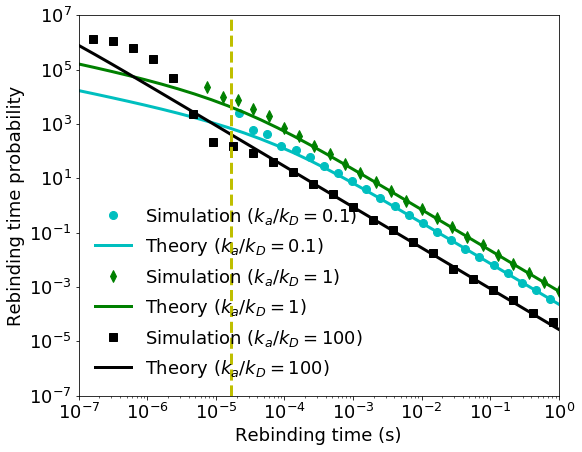

In [1]:
import sys
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler
from scipy import special
voxel_radius=0.005
D=1
tm = (4 * voxel_radius * voxel_radius) / (6 * D)
fig,ax1=plt.subplots(1,1,figsize=(8.6,7))
fs=18
ms=8
lw=3
names = ["kfac0.1trial700000","kfac1.0trial400000","kfac100.0trial800000"]
kfacs=[0.1,1,100]
kD = 4 * np.pi * (2 * voxel_radius) * D
R0=0.256318
R = 2*voxel_radius
ax1.set_prop_cycle(cycler('color', ['c', 'c','g','g','k', 'k']) )
mk=['o','d','s']

def phix(x):
    return special.erfcx(x)

def f(t):
    x = t**0.5
    return (1./math.pi**0.5 /x - phix(x))

def gethist(times,nt):
    hist, bin_edges = np.histogram(times,bins=np.logspace(np.log10(min(times)),np.log10(max(times)),30))
    tt = 0.5*(bin_edges[:-1]+bin_edges[1:])
    binwid = -(bin_edges[:-1]-bin_edges[1:])
    ft = hist/nt/binwid
    return tt,ft

def theorykaf(kfac,tt):
    ka = kD * kfac
    tmol = R*R/D/(1+ka/kD)**2
    tau = tt/tmol
    Nfactor = (ka*(1+ka/kD)*D/kD/R/R)
    plt.loglog(tt,f(tau)*Nfactor,'-',label='Theory ($k_a/k_D='+str(kfac)+'$)',linewidth=lw)
    return 

for i,name in enumerate(names):
    kfac=kfacs[i]
    ka = kD * kfac
    Pacc = ka / (6 * 2**0.5 * D * voxel_radius)
    times = np.loadtxt('/home/chew/outputdata/'+name,delimiter=',')
    nt = int(name[-6:])#number of trials
    print('preb',float(len(times))/nt,'theory',Pacc/(Pacc+ 1./R0 -1))
    dt= np.unique(np.sort(times))[1]
    times+=dt
    tt,ft=gethist(times,nt)
    ax1.plot(tt,ft,marker=mk[i],linestyle=' ',label='Simulation ($k_a/k_D='+str(kfac)+'$)',markersize=ms)
    T = np.logspace(-7,0,30)
    theorykaf(kfac,T)

ax1.plot([tm]*10,np.logspace(-7,7,10),'y--',linewidth=lw)
ax1.legend(loc=3,fontsize=fs,frameon=False)
ax1.set_xlabel('Rebinding time (s)',fontsize=fs)
ax1.set_ylabel('Rebinding time probability',fontsize=fs)
ax1.set_xlim([1e-7,1])
ax1.set_ylim(1e-7,1e7)    
ax1.tick_params(labelsize=fs)      
plt.savefig("/home/chew/ecellwork/figure/fig2",format='pdf',dpi=900)    

In [1]:
def dif(a,b):
    return (a-b)*100/a
dif(0.041666,0.0416586)

0.017760284164557733